# Object Detection with SSD
### Here we demostrate detection on example images using SSD with PyTorch

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

import numpy as np
import cv2
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    
from lib.layers import *
from lib.utils.config_parse_orginal_V2_VOC_COCO import cfg
from lib.modeling.model_builder import create_model
from lib.dataset.dataset_factory import load_data

## Build SSD300 in Test Phase
1. Build the architecture, specifyingsize of the input image (300),
    and number of object classes to score (21 for VOC dataset)
2. Next we load pretrained weights on the VOC0712 trainval dataset  

In [2]:
model, priorbox = create_model(cfg.MODEL)
model.load_state_dict(torch.load('./Weights/Original_V2_VOC_COCO/ssd_lite_mobilenet_v2_coco_epoch_150.pth'))
priors = Variable(priorbox.forward(), volatile=True)
detector = Detect(cfg.POST_PROCESS, priors)
test_loader = load_data(cfg.DATASET, 'test') if 'test' in cfg.PHASE1 else None

/storage/3050/FinogeevE/prj/ssds.pytorch-master_MobileNet_2/lib/layers/modules/l2norm.py:17: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(self.weight,self.gamma)
/storage/3050/FinogeevE/prj/ssds.pytorch-master_MobileNet_2/lib/modeling/model_builder.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  x = torch.autograd.Variable(x, volatile=True) #.cuda()


==>Feature map size:
[(19, 19), (10, 10), (5, 5), (3, 3), (2, 2), (1, 1)]


FileNotFoundError: [Errno 2] No such file or directory: './Weights/Original_V2_VOC_COCO/ssd_lite_mobilenet_v2_coco_epoch_150.pth'

## Load Image 
### Here we just load a sample image from the VOC07 dataset 

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
dataset = test_loader.dataset
print(len(dataset))
print(detector.num_classes)
NUM_IMAGE = 1319
img = dataset.pull_image(NUM_IMAGE)
rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()
scale = torch.tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]], dtype=torch.float)

NameError: name 'test_loader' is not defined

In [145]:
images = Variable(dataset.preproc(img)[0].unsqueeze(0).cuda(), volatile=True)
out = model(images, phase='eval')
detections = detector.forward(out)
detections.size()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """Entry point for launching an IPython kernel.


torch.Size([1, 21, 100, 5])

tensor(0.6886)
tensor(0.6075)
tensor(0.4751)
tensor(0.7351)
tensor(0.8818)


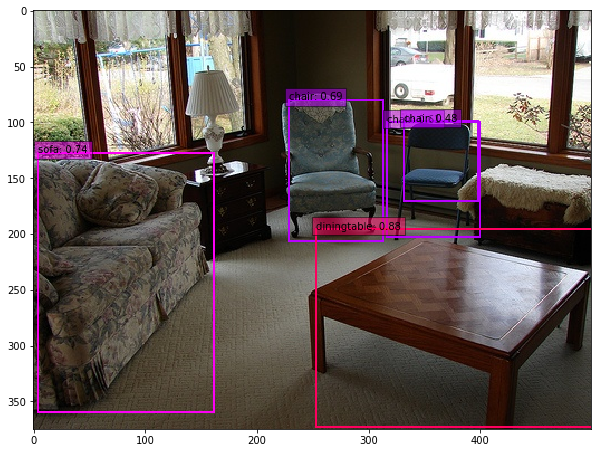

In [146]:
plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()
# labels = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train',\
#           'boat', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'bottle', 'chair',\
#           'couch', 'potted plant', 'dining table', 'tv']
labels = (  # always index 0
    'person', 'bicycle', 'car', 'motorbike',
    'aeroplane', 'bus', 'train', 'boat', 'bird',
    'cat', 'dog', 'horse', 'sheep',
    'cow', 'bottle', 'chair',
    'sofa', 'pottedplant', 'diningtable', 'tvmonitor')

for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.3:
        score = detections[0,i,j,0]
        print(score)
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
#         print(label_name)
#         print(score)
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1